In [1]:
import numpy as np
from scipy.stats import bernoulli
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import rbf_kernel

from local_SE import *


In [2]:
n = 1000
tau=1

Z = np.sort(np.random.uniform(0, 10, n)) 
# Z = np.linspace(0, 10, n)
A = np.zeros((n,n))
P= np.zeros((n,n))
P = rbf_kernel(Z.reshape(-1,1), gamma=1)
for i in range(n):
    for j in range(i+1):
        A[i,j] = bernoulli.rvs(P[i,j])
        A[j,i] = A[i,j]

In [3]:
def top_hat_weights(Z, poi, b, tau):
    weights = np.exp( - ((Z-Z[poi])**2)*tau)
    weights[weights > weights[poi-b]] = weights[poi-b]
    weights = weights / np.mean(weights)
    return weights

In [6]:
z=400
b=50
N=5

tau_vals_fine = np.linspace(1, 10, 10)
local_RMSE_fine = np.zeros((len(tau_vals_fine), N))

for k in range(N):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            A[i,j] = bernoulli.rvs(P[i,j])
            A[j,i] = A[i,j]
    for i, tau in enumerate(tau_vals_fine):
        weights = top_hat_weights(Z, z, b, tau)

        X_hat_local = local_embedding(A, 2, weights)

        # Calculate local RMSE
        P_hat_local = X_hat_local[(z-b):(z+b), :] @ X_hat_local[(z-b):(z+b), :].transpose()
        P_hat_local[P_hat_local>1] = 1
        P_hat_local[P_hat_local<0] = 0
        
        P_hat_local_error = abs(P_hat_local - P[(z-b):(z+b),(z-b):(z+b)])
        P_hat_local_rmse = np.sqrt(sum(sum(P_hat_local_error**2))/((2*b)**2))
        local_RMSE_fine[i, k] = P_hat_local_rmse
    
local_RMSE_fine_mean = np.mean(local_RMSE_fine, axis=1)
local_RMSE_fine_std = np.std(local_RMSE_fine, axis=1)
local_RMSE_fine_se = local_RMSE_fine_std / np.sqrt(N)


In [7]:
tau_vals=tau_vals_fine

In [8]:
import matplotlib as mpl

mpl.rcParams.update({'font.size': 11.5})  # Set the font size globally

/tmp/ipykernel_16888/601007430.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(tau_vals))


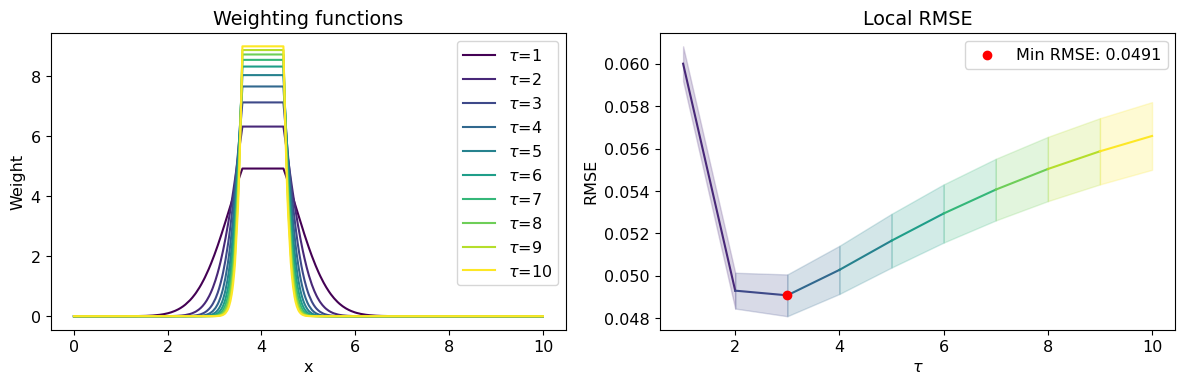

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Define a colormap
cmap = cm.get_cmap('viridis', len(tau_vals))
norm = mcolors.Normalize(vmin=min(tau_vals), vmax=max(tau_vals))

# Plot weights with colors based on tau
for i, tau in enumerate(tau_vals):
    color = cmap(norm(tau))
    axes[0].plot(Z, top_hat_weights(Z, z, b, tau), label=rf'$\tau$={int(tau)}', color=color)
axes[0].set_xlabel('x')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].set_title('Weighting functions')

# Plot local RMSE fine with a multi-colored line and colored error bars
for i in range(len(tau_vals_fine) - 1):
    color = cmap(norm(tau_vals_fine[i+1]))
    axes[1].plot(tau_vals_fine[i:i+2], local_RMSE_fine_mean[i:i+2], color=color)
    axes[1].fill_between(
        tau_vals_fine[i:i+2],
        local_RMSE_fine_mean[i:i+2] - local_RMSE_fine_se[i:i+2],
        local_RMSE_fine_mean[i:i+2] + local_RMSE_fine_se[i:i+2],
        color=color,
        alpha=0.2
    )

# Mark the tau that achieves the minimum in red
min_idx = np.argmin(local_RMSE_fine_mean)
min_rmse = local_RMSE_fine_mean[min_idx]
axes[1].scatter(tau_vals_fine[min_idx], min_rmse, color='red', label=f'Min RMSE: {min_rmse:.4f}', zorder=5)

axes[1].set_xlabel(r'$\tau$')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Local RMSE')
axes[1].legend()
plt.tight_layout()

In [10]:
# perform similar experiment, with weighting function that varies from uniform on [0,10] to top hat on [3.5, 4.5]
N=5

def subgraph_weights(Z, window_lower, window_upper):
    weights = np.ones_like(Z)
    weights[Z < window_lower] = 0
    weights[Z > window_upper] = 0
    weights = weights / np.mean(weights)
    return weights

#set window_vals to be 10 pairs of vals varying from [0,10] to [3.5, 4.5]
window_vals_lower = 4 - np.linspace(1.5, 0.5, 5)
window_vals_upper = 4 + np.linspace(1.5, 0.5, 5)

z_indices = np.where((Z >= 3.5) & (Z <= 4.5))[0]

subgraph_RMSE = np.zeros((len(window_vals_lower), N))
for k in range(N):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1):
            A[i,j] = bernoulli.rvs(P[i,j])
            A[j,i] = A[i,j]
    for i, (window_lower, window_upper) in enumerate(zip(window_vals_lower, window_vals_upper)):
        weights = subgraph_weights(Z, window_lower, window_upper)

        X_hat_local = local_embedding(A, 2, weights)

        # Calculate local RMSE on Z values within z_indices
        P_hat_local = X_hat_local[z_indices, :] @ X_hat_local[z_indices, :].transpose()
        P_hat_local[P_hat_local>1] = 1
        P_hat_local[P_hat_local<0] = 0
        P_hat_local_error = abs(P_hat_local - P[np.ix_(z_indices, z_indices)])
        P_hat_local_rmse = np.sqrt(np.sum(P_hat_local_error**2) / (len(z_indices)**2))
        subgraph_RMSE[i, k] = P_hat_local_rmse


subgraph_RMSE_mean = np.mean(subgraph_RMSE, axis=1)
subgraph_RMSE_std = np.std(subgraph_RMSE, axis=1)
subgraph_RMSE_se = subgraph_RMSE_std / np.sqrt(N)


/home/hs17630/Documents/LASE/local_SE.py:43: RuntimeWarning: divide by zero encountered in power
  X_new = np.diag(weights**(-0.5)) @ X_sym


/tmp/ipykernel_16888/1265188886.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r', len(window_vals_lower))


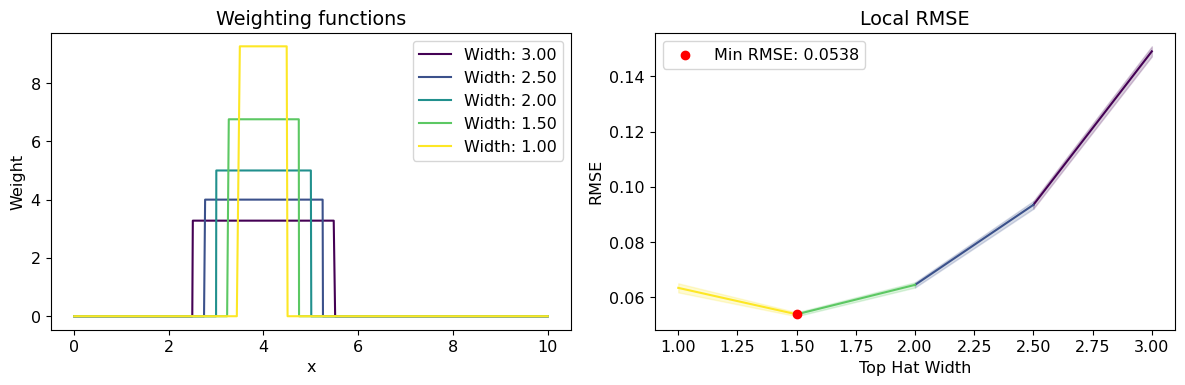

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Reverse the colormap
cmap = cm.get_cmap('viridis_r', len(window_vals_lower))

# Plot the weight functions colored by the width of the window
norm = mcolors.Normalize(vmin=min(window_vals_upper - window_vals_lower), vmax=max(window_vals_upper - window_vals_lower))

for i, (window_lower, window_upper) in enumerate(zip(window_vals_lower, window_vals_upper)):
    width = window_upper - window_lower
    color = cmap(norm(width))
    axes[0].plot(Z, subgraph_weights(Z, window_lower, window_upper), label=f'Width: {width:.2f}', color=color)

axes[0].set_xlabel('x')
axes[0].set_ylabel('Weight')
axes[0].legend()
axes[0].set_title('Weighting functions')

window_widths = window_vals_upper - window_vals_lower

# Plot RMSE vs window width
for i in range(len(window_widths) - 1):
    color = cmap(norm(0.5*(window_widths[i] + window_widths[i+1])))
    axes[1].plot(window_widths[i:i+2], subgraph_RMSE_mean[i:i+2], color=color)
    axes[1].fill_between(
        window_widths[i:i+2],
        subgraph_RMSE_mean[i:i+2] - subgraph_RMSE_se[i:i+2],
        subgraph_RMSE_mean[i:i+2] + subgraph_RMSE_se[i:i+2],
        color=color,
        alpha=0.2
    )

# Mark the minimum RMSE in red
# Exclude nan values when finding the minimum index
valid_indices = ~np.isnan(subgraph_RMSE_mean)
min_idx_subgraph = np.argmin(subgraph_RMSE_mean[valid_indices])
valid_window_widths = window_widths[valid_indices]
valid_subgraph_RMSE_mean = subgraph_RMSE_mean[valid_indices]

axes[1].scatter(valid_window_widths[min_idx_subgraph], valid_subgraph_RMSE_mean[min_idx_subgraph], color='red', label=f'Min RMSE: {valid_subgraph_RMSE_mean[min_idx_subgraph]:.4f}', zorder=5)

axes[1].set_xlabel('Top Hat Width')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Local RMSE')
axes[1].legend()

plt.tight_layout()